In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv("../../data/quarterly_data.csv", encoding = 'unicode_escape')

In [4]:
df1 = df.replace("..", np.nan)

In [5]:
df1

,Postal code,Building type,2010Q1 Price per square meter (EUR/m2),2010Q2 Price per square meter (EUR/m2),2010Q3 Price per square meter (EUR/m2),2010Q4 Price per square meter (EUR/m2),2011Q1 Price per square meter (EUR/m2),2011Q2 Price per square meter (EUR/m2),2011Q3 Price per square meter (EUR/m2),2011Q4 Price per square meter (EUR/m2),...,2019Q1 Price per square meter (EUR/m2),2019Q2 Price per square meter (EUR/m2),2019Q3 Price per square meter (EUR/m2),2019Q4 Price per square meter (EUR/m2),2020Q1 Price per square meter (EUR/m2),2020Q2 Price per square meter (EUR/m2),2020Q3 Price per square meter (EUR/m2),2020Q4 Price per square meter (EUR/m2),2021Q1* Price per square meter (EUR/m2),2021Q2* Price per square meter (EUR/m2)
0,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, one-room flat",5458,5347,5826,5566,5545,5812,5909,5856,...,7755,8332,8130,8068,7802,8543,9170,7517,8872,8596
1,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, two-room flat",5164,5021,5081,5006,5713,5866,5552,5614,...,6914,7694,6901,7435,7573,7398,7868,7700,7829,7974
2,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, three-room flat+",4944,5396,4828,5394,5571,5709,5450,5010,...,6883,6846,7379,6728,7205,6678,7178,7405,8053,8174
3,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Blocks of flats total,5168,5219,5181,5269,5632,5807,5630,5511,...,7043,7478,7476,7345,7460,7275,8058,7540,8188,8188
4,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Terraced houses total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10069,99980 Utsjoki Keskus (Utsjoki ),"Blocks of flats, two-room flat",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10070,99980 Utsjoki Keskus (Utsjoki ),"Blocks of flats, three-room flat+",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10071,99980 Utsjoki Keskus (Utsjoki ),Blocks of flats total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10072,99980 Utsjoki Keskus (Utsjoki ),Terraced houses total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# original source https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/
# summarize the number of rows with missing values for each column
for i in range(df1.shape[1]):
    n_miss = df1.iloc[:,i].isnull().sum()
    perc = n_miss / df1.shape[0] * 100
    print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))

> 0, Missing: 0 (0.0%)
> 1, Missing: 0 (0.0%)
> 2, Missing: 8466 (84.0%)
> 3, Missing: 8371 (83.1%)
> 4, Missing: 8437 (83.8%)
> 5, Missing: 8470 (84.1%)
> 6, Missing: 8429 (83.7%)
> 7, Missing: 8383 (83.2%)
> 8, Missing: 8401 (83.4%)
> 9, Missing: 8676 (86.1%)
> 10, Missing: 8517 (84.5%)
> 11, Missing: 8388 (83.3%)
> 12, Missing: 7979 (79.2%)
> 13, Missing: 8071 (80.1%)
> 14, Missing: 8538 (84.8%)
> 15, Missing: 8544 (84.8%)
> 16, Missing: 8596 (85.3%)
> 17, Missing: 8736 (86.7%)
> 18, Missing: 8683 (86.2%)
> 19, Missing: 8637 (85.7%)
> 20, Missing: 8653 (85.9%)
> 21, Missing: 8760 (87.0%)
> 22, Missing: 8687 (86.2%)
> 23, Missing: 8612 (85.5%)
> 24, Missing: 8579 (85.2%)
> 25, Missing: 8677 (86.1%)
> 26, Missing: 8747 (86.8%)
> 27, Missing: 8551 (84.9%)
> 28, Missing: 8647 (85.8%)
> 29, Missing: 8769 (87.0%)
> 30, Missing: 8640 (85.8%)
> 31, Missing: 8682 (86.2%)
> 32, Missing: 8575 (85.1%)
> 33, Missing: 8739 (86.7%)
> 34, Missing: 8721 (86.6%)
> 35, Missing: 8655 (85.9%)
> 36, Miss

In [7]:
## Categories and numerical features to different dfs

cat = df1.iloc[:,0:2]
num = df1.iloc[:,2:]
num_columns = num.columns

In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0)
num_imp = imp.fit_transform(num)

/Users/kenriippa/Documents/School/OP-Forecasting-Future-House-Prices/venv/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [9]:
df_num_imp = pd.DataFrame(num_imp, columns=num_columns)
df_num_imp

,2010Q1 Price per square meter (EUR/m2),2010Q2 Price per square meter (EUR/m2),2010Q3 Price per square meter (EUR/m2),2010Q4 Price per square meter (EUR/m2),2011Q1 Price per square meter (EUR/m2),2011Q2 Price per square meter (EUR/m2),2011Q3 Price per square meter (EUR/m2),2011Q4 Price per square meter (EUR/m2),2012Q1 Price per square meter (EUR/m2),2012Q2 Price per square meter (EUR/m2),...,2019Q1 Price per square meter (EUR/m2),2019Q2 Price per square meter (EUR/m2),2019Q3 Price per square meter (EUR/m2),2019Q4 Price per square meter (EUR/m2),2020Q1 Price per square meter (EUR/m2),2020Q2 Price per square meter (EUR/m2),2020Q3 Price per square meter (EUR/m2),2020Q4 Price per square meter (EUR/m2),2021Q1* Price per square meter (EUR/m2),2021Q2* Price per square meter (EUR/m2)
0,5458.000000,5347.000000,5826.000000,5566.000000,5545.000000,5812.000000,5909.000000,5856.000000,5785.000000,6436.000000,...,7755.000000,8332.000000,8130.000000,8068.0000,7802.000000,8543.000000,9170.000000,7517.000000,8872.000000,8596.000000
1,5164.000000,5021.000000,5081.000000,5006.000000,5713.000000,5866.000000,5552.000000,5614.000000,6020.000000,5814.000000,...,6914.000000,7694.000000,6901.000000,7435.0000,7573.000000,7398.000000,7868.000000,7700.000000,7829.000000,7974.000000
2,4944.000000,5396.000000,4828.000000,5394.000000,5571.000000,5709.000000,5450.000000,5010.000000,5704.000000,5466.000000,...,6883.000000,6846.000000,7379.000000,6728.0000,7205.000000,6678.000000,7178.000000,7405.000000,8053.000000,8174.000000
3,5168.000000,5219.000000,5181.000000,5269.000000,5632.000000,5807.000000,5630.000000,5511.000000,5843.000000,5899.000000,...,7043.000000,7478.000000,7476.000000,7345.0000,7460.000000,7275.000000,8058.000000,7540.000000,8188.000000,8188.000000
4,1783.222523,1824.975495,1837.301766,1822.620585,1869.018392,1898.716837,1894.228569,1862.702913,1900.623898,1930.519312,...,2084.801645,2117.757075,2101.019245,2069.1361,2135.629373,2152.308609,2173.893109,2172.261334,2219.056507,2290.004173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10069,1783.222523,1824.975495,1837.301766,1822.620585,1869.018392,1898.716837,1894.228569,1862.702913,1900.623898,1930.519312,...,2084.801645,2117.757075,2101.019245,2069.1361,2135.629373,2152.308609,2173.893109,2172.261334,2219.056507,2290.004173
10070,1783.222523,1824.975495,1837.301766,1822.620585,1869.018392,1898.716837,1894.228569,1862.702913,1900.623898,1930.519312,...,2084.801645,2117.757075,2101.019245,2069.1361,2135.629373,2152.308609,2173.893109,2172.261334,2219.056507,2290.004173
10071,1783.222523,1824.975495,1837.301766,1822.620585,1869.018392,1898.716837,1894.228569,1862.702913,1900.623898,1930.519312,...,2084.801645,2117.757075,2101.019245,2069.1361,2135.629373,2152.308609,2173.893109,2172.261334,2219.056507,2290.004173
10072,1783.222523,1824.975495,1837.301766,1822.620585,1869.018392,1898.716837,1894.228569,1862.702913,1900.623898,1930.519312,...,2084.801645,2117.757075,2101.019245,2069.1361,2135.629373,2152.308609,2173.893109,2172.261334,2219.056507,2290.004173


In [10]:
df_num_imp.isnull().sum()

2010Q1 Price per square meter (EUR/m2)     0
2010Q2 Price per square meter (EUR/m2)     0
2010Q3 Price per square meter (EUR/m2)     0
2010Q4 Price per square meter (EUR/m2)     0
2011Q1 Price per square meter (EUR/m2)     0
2011Q2 Price per square meter (EUR/m2)     0
2011Q3 Price per square meter (EUR/m2)     0
2011Q4 Price per square meter (EUR/m2)     0
2012Q1 Price per square meter (EUR/m2)     0
2012Q2 Price per square meter (EUR/m2)     0
2012Q3 Price per square meter (EUR/m2)     0
2012Q4 Price per square meter (EUR/m2)     0
2013Q1 Price per square meter (EUR/m2)     0
2013Q2 Price per square meter (EUR/m2)     0
2013Q3 Price per square meter (EUR/m2)     0
2013Q4 Price per square meter (EUR/m2)     0
2014Q1 Price per square meter (EUR/m2)     0
2014Q2 Price per square meter (EUR/m2)     0
2014Q3 Price per square meter (EUR/m2)     0
2014Q4 Price per square meter (EUR/m2)     0
2015Q1 Price per square meter (EUR/m2)     0
2015Q2 Price per square meter (EUR/m2)     0
2015Q3 Pri

In [11]:
df_imp = pd.concat([cat, df_num_imp],axis=1)

In [12]:
df_imp.head()

,Postal code,Building type,2010Q1 Price per square meter (EUR/m2),2010Q2 Price per square meter (EUR/m2),2010Q3 Price per square meter (EUR/m2),2010Q4 Price per square meter (EUR/m2),2011Q1 Price per square meter (EUR/m2),2011Q2 Price per square meter (EUR/m2),2011Q3 Price per square meter (EUR/m2),2011Q4 Price per square meter (EUR/m2),...,2019Q1 Price per square meter (EUR/m2),2019Q2 Price per square meter (EUR/m2),2019Q3 Price per square meter (EUR/m2),2019Q4 Price per square meter (EUR/m2),2020Q1 Price per square meter (EUR/m2),2020Q2 Price per square meter (EUR/m2),2020Q3 Price per square meter (EUR/m2),2020Q4 Price per square meter (EUR/m2),2021Q1* Price per square meter (EUR/m2),2021Q2* Price per square meter (EUR/m2)
0,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, one-room flat",5458.000000,5347.000000,5826.000000,5566.000000,5545.000000,5812.000000,5909.000000,5856.000000,...,7755.000000,8332.000000,8130.000000,8068.0000,7802.000000,8543.000000,9170.000000,7517.000000,8872.000000,8596.000000
1,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, two-room flat",5164.000000,5021.000000,5081.000000,5006.000000,5713.000000,5866.000000,5552.000000,5614.000000,...,6914.000000,7694.000000,6901.000000,7435.0000,7573.000000,7398.000000,7868.000000,7700.000000,7829.000000,7974.000000
2,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, three-room flat+",4944.000000,5396.000000,4828.000000,5394.000000,5571.000000,5709.000000,5450.000000,5010.000000,...,6883.000000,6846.000000,7379.000000,6728.0000,7205.000000,6678.000000,7178.000000,7405.000000,8053.000000,8174.000000
3,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Blocks of flats total,5168.000000,5219.000000,5181.000000,5269.000000,5632.000000,5807.000000,5630.000000,5511.000000,...,7043.000000,7478.000000,7476.000000,7345.0000,7460.000000,7275.000000,8058.000000,7540.000000,8188.000000,8188.000000
4,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Terraced houses total,1783.222523,1824.975495,1837.301766,1822.620585,1869.018392,1898.716837,1894.228569,1862.702913,...,2084.801645,2117.757075,2101.019245,2069.1361,2135.629373,2152.308609,2173.893109,2172.261334,2219.056507,2290.004173


In [13]:
df4 = df_imp.melt(id_vars=["Postal code", "Building type"],var_name="Quarter", value_name="EUR/m2")

In [14]:
df4.loc[df4["Postal code"] == "00100 Helsinki Keskusta - Etu-Töölö   (Helsinki )"]

,Postal code,Building type,Quarter,EUR/m2
0,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, one-room flat",2010Q1 Price per square meter (EUR/m2),5458.000000
1,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, two-room flat",2010Q1 Price per square meter (EUR/m2),5164.000000
2,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, three-room flat+",2010Q1 Price per square meter (EUR/m2),4944.000000
3,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Blocks of flats total,2010Q1 Price per square meter (EUR/m2),5168.000000
4,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Terraced houses total,2010Q1 Price per square meter (EUR/m2),1783.222523
...,...,...,...,...
453331,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, two-room flat",2021Q2* Price per square meter (EUR/m2),7974.000000
453332,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, three-room flat+",2021Q2* Price per square meter (EUR/m2),8174.000000
453333,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Blocks of flats total,2021Q2* Price per square meter (EUR/m2),8188.000000
453334,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Terraced houses total,2021Q2* Price per square meter (EUR/m2),2290.004173


In [108]:
### Regex to change quarters to datetime
import datetime as date

def quarter_to_datetime(row):
    dates = {"Q1": "1/1", "Q2":"1/4", "Q3":"1/7", "Q4":"1/10"}
    string = row.replace("*", "").split(" ")[0]
    year, quarter = string[:4], string[4:]
    datetime_str = dates[quarter] + "/" + year
    return date.datetime.strptime(datetime_str, '%d/%m/%Y')
    
    
df4["Quarter"] = df4["Quarter"].apply(lambda row: quarter_to_datetime(row))
df4

ValueError: value must be an integer, received <class 'str'> for year

In [16]:
### Split postal code and place

df4[['Postal code', 'Location']] = df4['Postal code'].str.split(' ', 1, expand=True)
df4

,Postal code,Building type,Quarter,EUR/m2,Location
0,00100,"Blocks of flats, one-room flat",2010-01-01,5458.000000,Helsinki Keskusta - Etu-Töölö (Helsinki )
1,00100,"Blocks of flats, two-room flat",2010-01-01,5164.000000,Helsinki Keskusta - Etu-Töölö (Helsinki )
2,00100,"Blocks of flats, three-room flat+",2010-01-01,4944.000000,Helsinki Keskusta - Etu-Töölö (Helsinki )
3,00100,Blocks of flats total,2010-01-01,5168.000000,Helsinki Keskusta - Etu-Töölö (Helsinki )
4,00100,Terraced houses total,2010-01-01,1783.222523,Helsinki Keskusta - Etu-Töölö (Helsinki )
...,...,...,...,...,...
463399,99980,"Blocks of flats, two-room flat",2021-01-04,2290.004173,Utsjoki Keskus (Utsjoki )
463400,99980,"Blocks of flats, three-room flat+",2021-01-04,2290.004173,Utsjoki Keskus (Utsjoki )
463401,99980,Blocks of flats total,2021-01-04,2290.004173,Utsjoki Keskus (Utsjoki )
463402,99980,Terraced houses total,2021-01-04,2290.004173,Utsjoki Keskus (Utsjoki )


In [17]:
import pgeocode
import time

In [18]:
postal_code_list = list(df4["Postal code"].unique())
nomi = pgeocode.Nominatim('fi')
location = nomi.query_postal_code(postal_code_list)

In [19]:
location

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,00100,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1714,24.9316,6.0
1,00120,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1632,24.9391,6.0
2,00130,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1645,24.9487,6.0
3,00140,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1578,24.9525,6.0
4,00150,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1570,24.9369,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1674,99830,FI,Saariselkä,Lapland,19.0,Pohjois-Lappi,197.0,Inari,148.0,68.4230,27.3965,6.0
1675,99870,FI,Inari,Lapland,19.0,Pohjois-Lappi,197.0,Inari,148.0,68.9287,26.9896,6.0
1676,99930,FI,Sevettijärvi,Lapland,19.0,Pohjois-Lappi,197.0,Inari,148.0,69.4918,28.5786,4.0
1677,99950,FI,Karigasniemi,Lapland,19.0,Pohjois-Lappi,197.0,Utsjoki,890.0,69.4729,25.9527,4.0


In [20]:
cond = location['latitude'].isna()
jalla = location.assign(cond1= cond)
jalla

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy,cond1
0,00100,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1714,24.9316,6.0,False
1,00120,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1632,24.9391,6.0,False
2,00130,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1645,24.9487,6.0,False
3,00140,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1578,24.9525,6.0,False
4,00150,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1570,24.9369,6.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674,99830,FI,Saariselkä,Lapland,19.0,Pohjois-Lappi,197.0,Inari,148.0,68.4230,27.3965,6.0,False
1675,99870,FI,Inari,Lapland,19.0,Pohjois-Lappi,197.0,Inari,148.0,68.9287,26.9896,6.0,False
1676,99930,FI,Sevettijärvi,Lapland,19.0,Pohjois-Lappi,197.0,Inari,148.0,69.4918,28.5786,4.0,False
1677,99950,FI,Karigasniemi,Lapland,19.0,Pohjois-Lappi,197.0,Utsjoki,890.0,69.4729,25.9527,4.0,False


In [21]:
## Find rows which are empty
# Source https://www.kite.com/python/answers/how-to-find-rows-with-nan-values-in-a-pandas-dataframe-in-python


is_NaN = location.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = location[row_has_NaN]
rows_with_NaN

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
37,00540,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1841,24.9785,NaN
289,08450,FI,Lohja,Uusimaa,1.0,Helsinki,11.0,Lohja,444.0,60.2713,23.9952,NaN
294,09120,FI,Karjalohja,Uusimaa,1.0,Helsinki,11.0,Lohja,444.0,60.2506,23.7101,NaN
307,10440,FI,Bollsta,Uusimaa,1.0,Raaseporin,14.0,Raseborg,710.0,60.1126,23.5225,NaN
317,10710,FI,Snappertuna,Uusimaa,1.0,Raaseporin,14.0,Raseborg,710.0,59.9782,23.7238,NaN
440,20100,FI,Turku,Southwest Finland,2.0,Turku,23.0,Turku,853.0,60.4449,22.2261,NaN
565,25650,FI,Strömma,Southwest Finland,2.0,Åboland-Turunmaa,21.0,Kimitoön,322.0,60.1888,22.8499,NaN
576,26410,FI,Kaaro,Satakunta,4.0,Rauma,41.0,Rauma,684.0,61.1767,21.5183,NaN
852,41350,FI,Laukaa As,Central Finland Region,13.0,Jyväskylä,131.0,Laukaa,410.0,62.4267,25.8850,NaN
859,41530,FI,Veneranta,Central Finland Region,13.0,Jyväskylä,131.0,Hankasalmi,77.0,62.3759,26.3465,NaN


In [22]:
###. WORK IN PROGRESS (93999 FOR KUUSAMO)
# THIS HAS TO BE ADDED MANUALLY

wanted_features_location = location[["postal_code", 
                                     "place_name", 
                                     "state_name", 
                                     "county_name", 
                                     "latitude", 
                                     "longitude"]]
wanted_features_location = wanted_features_location.rename(columns={"postal_code": "Postal code"})

In [23]:
df_merge = pd.merge(df4, wanted_features_location, on="Postal code")

In [24]:
df_merge

,Postal code,Building type,Quarter,EUR/m2,Location,place_name,state_name,county_name,latitude,longitude
0,00100,"Blocks of flats, one-room flat",2010-01-01,5458.000000,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
1,00100,"Blocks of flats, two-room flat",2010-01-01,5164.000000,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
2,00100,"Blocks of flats, three-room flat+",2010-01-01,4944.000000,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
3,00100,Blocks of flats total,2010-01-01,5168.000000,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
4,00100,Terraced houses total,2010-01-01,1783.222523,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
...,...,...,...,...,...,...,...,...,...,...
463399,99980,"Blocks of flats, two-room flat",2021-01-04,2290.004173,Utsjoki Keskus (Utsjoki ),Utsjoki,Lapland,Pohjois-Lappi,69.8467,26.8907
463400,99980,"Blocks of flats, three-room flat+",2021-01-04,2290.004173,Utsjoki Keskus (Utsjoki ),Utsjoki,Lapland,Pohjois-Lappi,69.8467,26.8907
463401,99980,Blocks of flats total,2021-01-04,2290.004173,Utsjoki Keskus (Utsjoki ),Utsjoki,Lapland,Pohjois-Lappi,69.8467,26.8907
463402,99980,Terraced houses total,2021-01-04,2290.004173,Utsjoki Keskus (Utsjoki ),Utsjoki,Lapland,Pohjois-Lappi,69.8467,26.8907


In [25]:
#Some columns are missing their geolocation features :(

for i in range(df_merge.shape[1]):
    n_miss = df_merge.iloc[:,i].isnull().sum()
    perc = n_miss / df1.shape[0] * 100
    print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))

> 0, Missing: 0 (0.0%)
> 1, Missing: 0 (0.0%)
> 2, Missing: 0 (0.0%)
> 3, Missing: 0 (0.0%)
> 4, Missing: 0 (0.0%)
> 5, Missing: 276 (2.7%)
> 6, Missing: 276 (2.7%)
> 7, Missing: 276 (2.7%)
> 8, Missing: 276 (2.7%)
> 9, Missing: 276 (2.7%)


In [26]:
df_merge.columns

Index(['Postal code', 'Building type', 'Quarter', 'EUR/m2', 'Location',
       'place_name', 'state_name', 'county_name', 'latitude', 'longitude'],
      dtype='object')

In [27]:
df_merge["Building type"].unique()

array(['Blocks of flats, one-room flat', 'Blocks of flats, two-room flat',
       'Blocks of flats, three-room flat+', 'Blocks of flats total',
       'Terraced houses total', 'Building types total'], dtype=object)

# Save a dataset for model testing

In [28]:
wanted_columns = ['Postal code', 'Building type', 'Quarter', 'EUR/m2','latitude', 'longitude']
not_wanted_building_types = ['Building types total','Blocks of flats total']
df_only_houses = df_merge[~df_merge["Building type"].isin(not_wanted_building_types)].reset_index(drop=True)
df_only_houses["EUR/m2"] = df_only_houses["EUR/m2"].astype(int)

In [29]:
df_only_houses["Building type"].unique()

array(['Blocks of flats, one-room flat', 'Blocks of flats, two-room flat',
       'Blocks of flats, three-room flat+', 'Terraced houses total'],
      dtype=object)

In [30]:
### Rename building types


def rename_building(row):
    dic = {'Blocks of flats, one-room flat':'one-room','Blocks of flats, two-room flat':'two-room',
           'Blocks of flats, three-room flat+':'three or more room', 'Terraced houses total':'terrace house'}
    return dic[row]

df_only_houses2 = df_only_houses
df_only_houses2["Building type"] = df_only_houses2["Building type"].apply(lambda r: rename_building(r))

In [31]:
data = df_only_houses2[wanted_columns]

In [32]:
data.head()

,Postal code,Building type,Quarter,EUR/m2,latitude,longitude
0,00100,one-room,2010-01-01,5458,60.1714,24.9316
1,00100,two-room,2010-01-01,5164,60.1714,24.9316
2,00100,three or more room,2010-01-01,4944,60.1714,24.9316
3,00100,terrace house,2010-01-01,1783,60.1714,24.9316
4,00100,one-room,2010-01-04,5347,60.1714,24.9316


In [33]:
data.to_csv("df_geo_imp.csv")

## Value of square meter of cities Q2 2021

In [34]:
Q2_2021__one_room = df_merge[(df_merge["Quarter"] == "2021-01-04") & (df_merge["Building type"] == "Blocks of flats, one-room flat")]


In [35]:
Q2_2021__one_room

,Postal code,Building type,Quarter,EUR/m2,Location,place_name,state_name,county_name,latitude,longitude
270,00100,"Blocks of flats, one-room flat",2021-01-04,8596.000000,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
546,00120,"Blocks of flats, one-room flat",2021-01-04,8549.699924,Punavuori (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1632,24.9391
822,00130,"Blocks of flats, one-room flat",2021-01-04,2290.004173,Kaartinkaupunki (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1645,24.9487
1098,00140,"Blocks of flats, one-room flat",2021-01-04,10025.116718,Kaivopuisto - Ullanlinna (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1578,24.9525
1374,00150,"Blocks of flats, one-room flat",2021-01-04,9420.000000,Eira - Hernesaari (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1570,24.9369
...,...,...,...,...,...,...,...,...,...,...
462294,99830,"Blocks of flats, one-room flat",2021-01-04,2290.004173,Saariselkä (Inari ),Saariselkä,Lapland,Pohjois-Lappi,68.4230,27.3965
462570,99870,"Blocks of flats, one-room flat",2021-01-04,2290.004173,Inari Keskus-Lemmenjoki (Inari ),Inari,Lapland,Pohjois-Lappi,68.9287,26.9896
462846,99930,"Blocks of flats, one-room flat",2021-01-04,2290.004173,Sevettijärvi-Näätämö (Inari ),Sevettijärvi,Lapland,Pohjois-Lappi,69.4918,28.5786
463122,99950,"Blocks of flats, one-room flat",2021-01-04,2290.004173,Karigasniemi (Utsjoki ),Karigasniemi,Lapland,Pohjois-Lappi,69.4729,25.9527


No handles with labels found to put in legend.


Text(0.5, 1.0, 'Q2 2021 Blocks of flats, one-room flat')

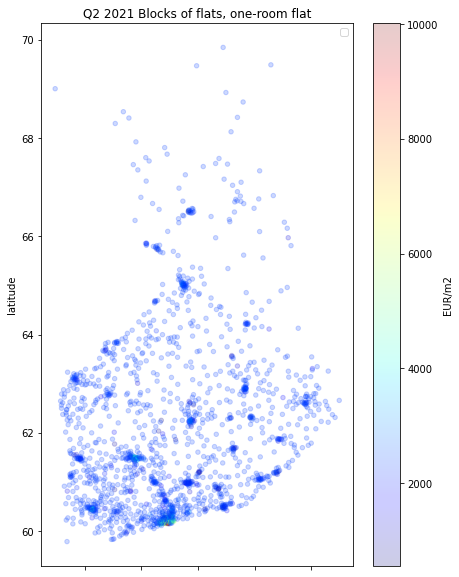

In [36]:
Q2_2021__one_room.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, figsize=(7,10),
 c="EUR/m2", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()
plt.title("Q2 2021 Blocks of flats, one-room flat")

### Only Helsinki

No handles with labels found to put in legend.


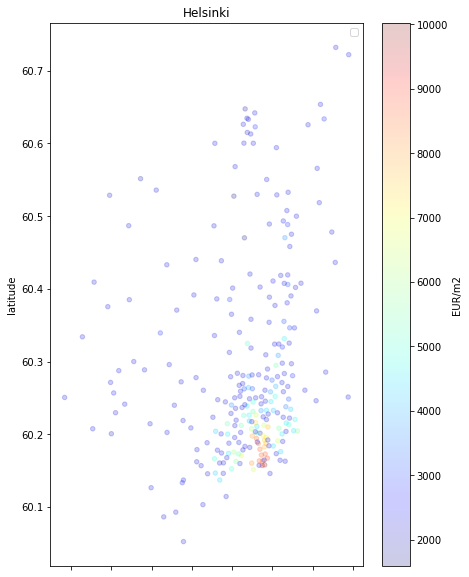

In [37]:
helsinki_df = Q2_2021__one_room[Q2_2021__one_room["county_name"] == "Helsinki"]

helsinki_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, figsize=(7,10),
 c="EUR/m2", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.title("Helsinki")
plt.legend()

## Whole uusimaa

No handles with labels found to put in legend.


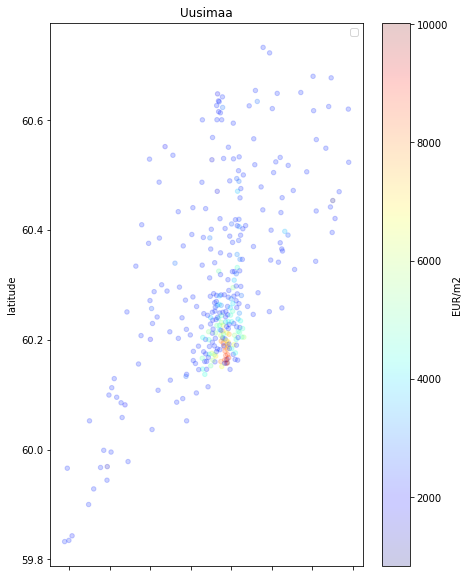

In [38]:
uusimaa_df = Q2_2021__one_room[Q2_2021__one_room["state_name"] == "Uusimaa"]

uusimaa_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, figsize=(7,10),
 c="EUR/m2", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.title("Uusimaa")
plt.legend()

In [39]:
uusimaa_df.describe()

,EUR/m2,latitude,longitude
count,322.000000,322.000000,322.000000
mean,3077.228315,60.294580,24.847279
std,1648.009285,0.165263,0.591155
min,832.141758,59.832500,22.940100
25%,2290.004173,60.190300,24.683450
50%,2290.004173,60.252100,24.897000
75%,2876.277990,60.396800,25.073975
max,10025.116718,60.732200,26.452100


In [40]:
helsinki_df.sort_values(by="EUR/m2", ascending=False).head()

,Postal code,Building type,Quarter,EUR/m2,Location,place_name,state_name,county_name,latitude,longitude
1098,00140,"Blocks of flats, one-room flat",2021-01-04,10025.116718,Kaivopuisto - Ullanlinna (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1578,24.9525
1374,00150,"Blocks of flats, one-room flat",2021-01-04,9420.000000,Eira - Hernesaari (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1570,24.9369
1650,00160,"Blocks of flats, one-room flat",2021-01-04,8874.728222,Katajanokka (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1671,24.9684
2202,00180,"Blocks of flats, one-room flat",2021-01-04,8684.000000,Kamppi - Ruoholahti (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1634,24.9190
270,00100,"Blocks of flats, one-room flat",2021-01-04,8596.000000,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316


## Model prototype (just for testing web app)

It is worth noticing that this model has been built with imputed data. 
Therefore, model's evaluation can be wrong since the imputed data has been used for that step. 

In [41]:
import joblib

data.head()
data2 = data.drop("Postal code", axis=1)
data2["Quarter"] = data2["Quarter"].astype(str)

In [42]:
data2.isna().sum()

Building type      0
Quarter            0
EUR/m2             0
latitude         184
longitude        184
dtype: int64

In [43]:
data3 = data2.dropna().reset_index()

In [44]:
# Building type and Quarter to one hot encoding
from sklearn.preprocessing import OneHotEncoder

num = data3[["longitude", "latitude", "EUR/m2"]]
cat = data3[["Building type", "Quarter"]]

In [45]:
cat

,Building type,Quarter
0,one-room,2010-01-01
1,two-room,2010-01-01
2,three or more room,2010-01-01
3,terrace house,2010-01-01
4,one-room,2010-01-04
...,...,...
308747,terrace house,2021-01-01
308748,one-room,2021-01-04
308749,two-room,2021-01-04
308750,three or more room,2021-01-04


In [46]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(cat)
oh_cat = enc.transform(cat).toarray()

In [47]:
oh_cat_features = enc.get_feature_names(["Building type", "Quarter"])
cat_df = pd.DataFrame(oh_cat, columns=oh_cat_features)

/Users/kenriippa/Documents/School/OP-Forecasting-Future-House-Prices/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [48]:
# Save encoder for streamlit
joblib.dump(enc, "onehot_encoder.pkl", compress=1)

['onehot_encoder.pkl']

In [49]:
data4 = pd.concat([cat_df,num],axis=1)
data4

,Building type_one-room,Building type_terrace house,Building type_three or more room,Building type_two-room,Quarter_2010-01-01,Quarter_2010-01-04,Quarter_2010-01-07,Quarter_2010-01-10,Quarter_2011-01-01,Quarter_2011-01-04,...,Quarter_2019-01-10,Quarter_2020-01-01,Quarter_2020-01-04,Quarter_2020-01-07,Quarter_2020-01-10,Quarter_2021-01-01,Quarter_2021-01-04,longitude,latitude,EUR/m2
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.9316,60.1714,5458
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.9316,60.1714,5164
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.9316,60.1714,4944
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.9316,60.1714,1783
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.9316,60.1714,5347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308747,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,26.8907,69.8467,2219
308748,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,26.8907,69.8467,2290
308749,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,26.8907,69.8467,2290
308750,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,26.8907,69.8467,2290


In [50]:
cat_test = np.array(["one-room", "2021-01-04"])
tuloe = enc.transform(cat_test.reshape(1,-1)).toarray()
print(tuloe)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]]


/Users/kenriippa/Documents/School/OP-Forecasting-Future-House-Prices/venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [51]:
## Test and train sets

train = data4[data4["Quarter_2021-01-04"] == 0.0]
test = data4[data4["Quarter_2021-01-04"] == 1.0]

In [52]:
X_feat = list(data4.columns)
X_feat.remove('EUR/m2')

X_train, X_test = train[X_feat], test[X_feat]
y_train, y_test = train['EUR/m2'], test['EUR/m2']


In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


regr = RandomForestRegressor(n_estimators=10, random_state=7)
regr.fit(X_train, y_train)

pred = regr.predict(X_test)
mean_absolute_error(y_test, pred)

353.85960965435044

In [54]:
joblib.dump(regr,'housing_regr.pkl',compress=1)

['housing_regr.pkl']

## Time series forecasting

In [109]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py

In [110]:
df = pd.read_csv("../Bruce/no_nans.csv")

In [111]:
df["time"] = df["time"].apply(lambda row: quarter_to_datetime(row))

In [112]:
df.head()

,time,00100,00260,00360,00500,00520,00730,00820,01280,01300,...,33200,33560,33580,33710,33820,33850,33960,36200,37120,40520
0,2010-01-01,5168.0,4873.0,2756.0,4058.0,3317.0,3006.0,2652.0,2098.0,2616.0,...,2827.0,1951.0,2152.0,1760.0,1859.0,1227.0,1897.0,1747.0,1613.0,1968.0
1,2010-04-01,5219.0,5086.0,3051.0,4111.0,3706.0,3070.0,2561.0,2045.0,2688.0,...,3094.0,1816.0,2039.0,1803.0,1970.0,1254.0,2026.0,1659.0,1542.0,2110.0
2,2010-07-01,5181.0,4939.0,2889.0,4247.0,3672.0,2944.0,2632.0,2210.0,2814.0,...,3001.0,2081.0,1978.0,1851.0,1916.0,1338.0,1700.0,1851.0,1582.0,2096.0
3,2010-10-01,5269.0,4906.0,3037.0,4226.0,3681.0,3046.0,2580.0,2359.0,2727.0,...,2990.0,1963.0,2102.0,1740.0,1980.0,1287.0,1881.0,1715.0,1745.0,2180.0
4,2011-01-01,5632.0,5272.0,3188.0,4342.0,3654.0,3061.0,2793.0,2165.0,2734.0,...,3122.0,2142.0,2181.0,1838.0,1851.0,1398.0,1847.0,1836.0,1660.0,2116.0


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    46 non-null     datetime64[ns]
 1   00100   46 non-null     float64       
 2   00260   46 non-null     float64       
 3   00360   46 non-null     float64       
 4   00500   46 non-null     float64       
 5   00520   46 non-null     float64       
 6   00730   46 non-null     float64       
 7   00820   46 non-null     float64       
 8   01280   46 non-null     float64       
 9   01300   46 non-null     float64       
 10  01450   46 non-null     float64       
 11  02200   46 non-null     float64       
 12  02210   46 non-null     float64       
 13  02320   46 non-null     float64       
 14  02400   46 non-null     float64       
 15  02760   46 non-null     float64       
 16  03100   46 non-null     float64       
 17  04410   46 non-null     float64       
 18  06100   46 n

In [114]:
# Just testing with 00100

df_00100 = df[["00100", "time"]]
df_00100 = df_00100.rename(columns={"00100":"y","time":"ds"})
df_00100.tail()

,y,ds
41,7275.0,2020-04-01
42,8058.0,2020-07-01
43,7540.0,2020-10-01
44,8188.0,2021-01-01
45,8188.0,2021-04-01


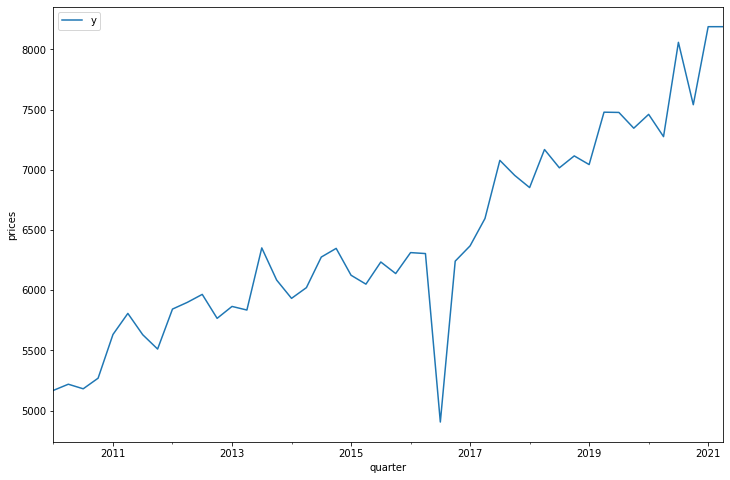

In [115]:
ax = df_00100.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel("prices")
ax.set_xlabel('quarter')

plt.show()

In [116]:
df_00100["ds"]

0    2010-01-01
1    2010-04-01
2    2010-07-01
3    2010-10-01
4    2011-01-01
5    2011-04-01
6    2011-07-01
7    2011-10-01
8    2012-01-01
9    2012-04-01
10   2012-07-01
11   2012-10-01
12   2013-01-01
13   2013-04-01
14   2013-07-01
15   2013-10-01
16   2014-01-01
17   2014-04-01
18   2014-07-01
19   2014-10-01
20   2015-01-01
21   2015-04-01
22   2015-07-01
23   2015-10-01
24   2016-01-01
25   2016-04-01
26   2016-07-01
27   2016-10-01
28   2017-01-01
29   2017-04-01
30   2017-07-01
31   2017-10-01
32   2018-01-01
33   2018-04-01
34   2018-07-01
35   2018-10-01
36   2019-01-01
37   2019-04-01
38   2019-07-01
39   2019-10-01
40   2020-01-01
41   2020-04-01
42   2020-07-01
43   2020-10-01
44   2021-01-01
45   2021-04-01
Name: ds, dtype: datetime64[ns]

In [117]:
# Setting up the model
prop = Prophet(interval_width=0.95)

In [118]:
prop.fit(df_00100)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -56.5006


Iteration  1. Log joint probability =    64.4408. Improved by 120.941.
Iteration  2. Log joint probability =    93.9887. Improved by 29.5479.
Iteration  3. Log joint probability =    110.688. Improved by 16.6991.
Iteration  4. Log joint probability =    122.382. Improved by 11.6938.
Iteration  5. Log joint probability =    125.432. Improved by 3.05013.
Iteration  6. Log joint probability =    125.445. Improved by 0.013562.
Iteration  7. Log joint probability =    125.604. Improved by 0.158237.
Iteration  8. Log joint probability =    125.653. Improved by 0.0497161.
Iteration  9. Log joint probability =    125.678. Improved by 0.0246621.
Iteration 10. Log joint probability =    125.721. Improved by 0.0428701.
Iteration 11. Log joint probability =    125.797. Improved by 0.0758697.
Iteration 12. Log joint probability =    125.834. Improved by 0.0376473.
Iteration 13. Log joint probability =    125.843. Improved by 0.00888646.
Iteration 14. Log joint probability =    125.953. Improved by 

In [119]:
def make_dates_from_string(string):
    return date.datetime.strptime(string, '%d/%m/%Y')


future_dates = ["1/7/2021", "1/10/2021", 
                "1/1/2022", "1/4/2022", "1/7/2022", "1/10/2022", 
                "1/1/2023", "1/4/2023", "1/7/2023", "1/10/2023",
                "1/1/2024", "1/4/2024"]
future_dates = [make_dates_from_string(d) for d in future_dates]
future_df = pd.DataFrame({"ds": future_dates})
future_df.head()

,ds
0,2021-07-01
1,2021-10-01
2,2022-01-01
3,2022-04-01
4,2022-07-01


In [120]:
forecast = prop.predict(future_df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2021-07-01,8071.109243,7515.334716,8591.844776
1,2021-10-01,8141.792022,7608.339941,8694.807717
2,2022-01-01,8210.335602,7668.937569,8695.553063
3,2022-04-01,8371.715956,7834.766928,8898.926561
4,2022-07-01,8489.735187,7921.371736,9058.580598


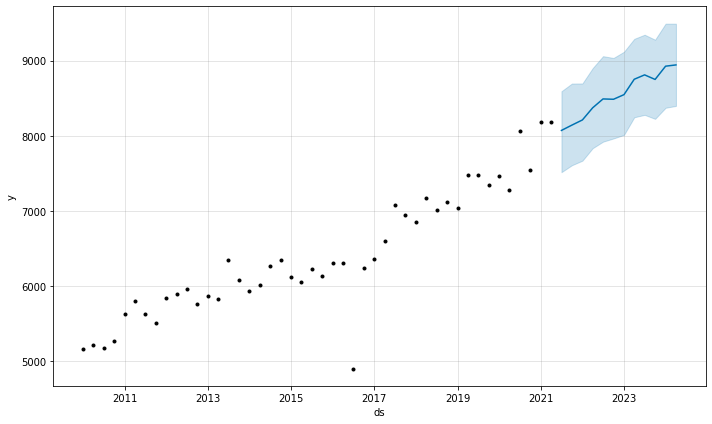

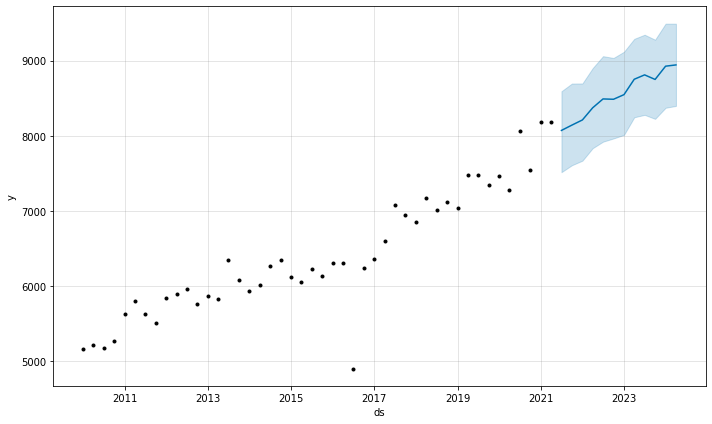

In [121]:
prop.plot(forecast, uncertainty=True)